# Dmytro Shapovalov, Daniil Stroievskyi: Image-Synthesis on CelebA dataset

In [47]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import wandb
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import time
from IPython.display import display

Combining all datasets into one, converting the range of binary attribute values from (-1 or 1) to (0 or 1), adding a path to the image for each sample, and saving the dataset in a .csv file for faster data reading in the future.

In [ ]:
if not os.path.exists('celeba_dataset.csv'):
    img_path='CelebA/images'
    identity_path='CelebA/attributes/identity_CelebA.txt'
    attr_path='CelebA/attributes/list_attr_celeba.txt'
    bbox_path='CelebA/attributes/list_bbox_celeba.txt'
    landmarks_path='CelebA/attributes/list_landmarks_align_celeba.txt'


    # Loading datasets
    df_attr = pd.read_csv(attr_path, delim_whitespace=True, header=0)
    df_identity = pd.read_csv(identity_path, delim_whitespace=True, header=0)
    df_bbox = pd.read_csv(bbox_path, delim_whitespace=True, header=0)
    df_landmarks = pd.read_csv(landmarks_path, delim_whitespace=True, header=0)

    # Converting -1 to 0
    attr_columns = [col for col in df_attr.columns if col != 'image_id']
    for col in attr_columns:
        df_attr[col] = df_attr[col].replace(-1, 0)


    # Merging all datasets
    df = df_attr.copy()
    df = df.merge(df_identity, on='image_id', how='left')
    df = df.merge(df_bbox, on='image_id', how='left')
    df = df.merge(df_landmarks, on='image_id', how='left')

    # Adding image path attribute
    df['image_path'] = df['image_id'].apply(lambda x: os.path.join(img_path, x))

    # Saving to csv file
    df.to_csv('celeba_dataset.csv', index=False)

Reading data from our file into a pandas dataframe.

In [48]:
df = pd.read_csv('celeba_dataset.csv', sep=None, engine='python');

Initializing the function for visualizing the image and attribute values of a single sample.

In [49]:
def show_image_info(data, image_id):
    # Finding row
    img_row = data[data["image_id"] == image_id]
    img_path = img_row["image_path"].iloc[0]

    # Loading image
    img = Image.open(img_path)
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(image_id)
    plt.show()

    # Attributes
    attrs = img_row.T
    attrs.columns = ["value"]
    print("Attributes:")
    display(attrs)

Now we can see what the samples from the dataset look like. Each sample contains an image of a person with a resolution of 178x218 and various attributes, such as gender, different facial features, hair color, the presence of various accessories, etc., as well as the coordinates of the face and its individual parts, such as the eyes, nose, and mouth in the photo.

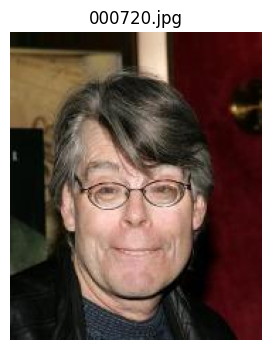

Attributes:


,value
image_id,000720.jpg
5_o_Clock_Shadow,0
Arched_Eyebrows,0
Attractive,0
Bags_Under_Eyes,0
Bald,0
Bangs,0
Big_Lips,0
Big_Nose,0
Black_Hair,0


In [50]:
show_image_info(df, "000720.jpg")

Here we can see that out dataset has 202599 samples, and each of them has 57 attributes. Which is more than enough to train our model.

In [51]:
print(f"Number of records (rows): {df.shape[0]}")
print(f"Number of attributes (columns): {df.shape[1]}")

Number of records (rows): 202599
Number of attributes (columns): 57


All of them have int64 type (0 or 1 in our case) except 'image_id' and 'image_path' attrbiutes which are strings.

In [52]:
df.dtypes

image_id               object
5_o_Clock_Shadow        int64
Arched_Eyebrows         int64
Attractive              int64
Bags_Under_Eyes         int64
Bald                    int64
Bangs                   int64
Big_Lips                int64
Big_Nose                int64
Black_Hair              int64
Blond_Hair              int64
Blurry                  int64
Brown_Hair              int64
Bushy_Eyebrows          int64
Chubby                  int64
Double_Chin             int64
Eyeglasses              int64
Goatee                  int64
Gray_Hair               int64
Heavy_Makeup            int64
High_Cheekbones         int64
Male                    int64
Mouth_Slightly_Open     int64
Mustache                int64
Narrow_Eyes             int64
No_Beard                int64
Oval_Face               int64
Pale_Skin               int64
Pointy_Nose             int64
Receding_Hairline       int64
Rosy_Cheeks             int64
Sideburns               int64
Smiling                 int64
Straight_H

Dataset has 0 missing values.

In [53]:
df.isna().sum()

image_id               0
5_o_Clock_Shadow       0
Arched_Eyebrows        0
Attractive             0
Bags_Under_Eyes        0
Bald                   0
Bangs                  0
Big_Lips               0
Big_Nose               0
Black_Hair             0
Blond_Hair             0
Blurry                 0
Brown_Hair             0
Bushy_Eyebrows         0
Chubby                 0
Double_Chin            0
Eyeglasses             0
Goatee                 0
Gray_Hair              0
Heavy_Makeup           0
High_Cheekbones        0
Male                   0
Mouth_Slightly_Open    0
Mustache               0
Narrow_Eyes            0
No_Beard               0
Oval_Face              0
Pale_Skin              0
Pointy_Nose            0
Receding_Hairline      0
Rosy_Cheeks            0
Sideburns              0
Smiling                0
Straight_Hair          0
Wavy_Hair              0
Wearing_Earrings       0
Wearing_Hat            0
Wearing_Lipstick       0
Wearing_Necklace       0
Wearing_Necktie        0


And dataset has 0 duplicated samples, which means that we don't need to clear or regulate it somehow.

In [54]:
df.duplicated().sum()

np.int64(0)

Now we need to crop and resize all our images to 64x64 because with fewer pixels in each photo, training our model will be faster and easier. First, we crop all images to a square format because pytorch works much better with this format. Then we resize the images to a resolution of 64x64.

In [55]:
if not os.path.exists('CelebA/images_cropped_64'):
    os.makedirs('CelebA/images_cropped_64')

    for row in df.itertuples():
        img_path = row.image_path
        img = Image.open(img_path)

        # Cropping to 178x178
        img_cropped = img.crop((0, 20, 178, 198))

        # Resizing to 64x64
        img_resized = img_cropped.resize((64, 64), Image.BICUBIC)

        # Saving to folder
        save_path = os.path.join('CelebA/images_cropped_64', row.image_id)
        img_resized.save(save_path)

For our first basic model we will only use one attribute, and it will be gender (male/female). We're deleting all other attributes, changing image pathes to new folder with cropped ones, and saving it to .csv file.

In [56]:
if not os.path.exists('celeba_reduced.csv'):
    df = df[['image_id', 'Male']]

    df['image_path'] = df['image_id'].apply(lambda x: os.path.join('CelebA/images_cropped_64', x))
    df = df.drop('image_id', axis=1)

    # Saving to csv file
    output_csv = 'celeba_reduced.csv'
    df.to_csv(output_csv, index=False)

else:
    df = pd.read_csv('celeba_reduced.csv', sep=None, engine='python');

In our case, we are using an Nvidia graphics card, so we will use Nvidia's CUDA technology, which allows calculations to be performed on graphics processors and is perfectly compatible with PyTorch.

In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


Initializing the image loading function. In order to avoid loading images from disk each time, we immediately transport them to tensors and save them to cache.

In [58]:
def load_images(df, transform):
    dir = 'cache_images'
    os.makedirs(dir, exist_ok=True)

    cache_key = f"cache_{len(df)}_Male.pt"
    cache_path = os.path.join(dir, cache_key)

    # If already cached
    if os.path.exists(cache_path):
        images_tensor, labels_tensor = torch.load(cache_path)
        return images_tensor, labels_tensor

    images, labels = [], []

    # Transporting images to tensors
    for idx in range(len(df)):
        img_path = df.iloc[idx]['image_path']
        attr = df.iloc[idx]['Male']

        img = Image.open(img_path).convert('RGB')

        img = transform(img)

        images.append(img)
        labels.append(attr)

    images_tensor = torch.stack(images)
    labels_tensor = torch.tensor(labels, dtype=torch.float32)

    # Saving cache
    torch.save((images_tensor, labels_tensor), cache_path)
    return images_tensor, labels_tensor

The function creates a transformer that will convert photos into tensors, normalize the pixel value range, and pass it to our load_images function.

In [59]:
def prepare_dataset(df):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])

    return load_images(df, transform)

In [ ]:
images, labels = prepare_dataset(df)

### Implementing a function for initializing the generator:

First, label embedding occurs, meaning that our transmitted attribute values are converted into a more useful vector that the network can work with. More specifically, our single attribute “male” is converted into a 128-dimensional vector of various hidden values that the network must arrive at on its own, but initially these are small random numbers.

Next, the generator initializes a fully connected layer which converts random noise and the vector of values into a 4x4 image template with 512 channels that carry information about various abstract data for our generator.

Then it creates convolution blocks that will gradually turn the template into a finished photo. The template will double in size and halve the number of channels until a 64x64 photo with 3 channels (RGB) produced.

And finally, we add all three layers to the Module Dictionary, a layer container designed specifically for PyTorch.

In [60]:
def create_generator(num_attrs, noise_dim):
    # Label embedding
    labels = nn.Sequential(
        nn.Linear(num_attrs, 128),
        nn.LeakyReLU(0.2, inplace=True)
    )

    # [noise + labels] -> [512, 4, 4]
    fc = nn.Sequential(
        nn.Linear(noise_dim + 128, 512 * 4 * 4),
        nn.BatchNorm1d(512 * 4 * 4),
        nn.LeakyReLU(0.2, inplace=True)
    )

    conv_blocks = nn.Sequential(
        # 4x4 -> 8x8
        nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),

        # 8x8 -> 16x16
        nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),

        # 16x16 -> 32x32
        nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),

        # 32x32 -> 64x64
        nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
        nn.Tanh()
    )

    generator = nn.ModuleDict({
        'label_embedding': labels,
        'fc': fc,
        'conv_blocks': conv_blocks
    })

    return generator

Initializing the forward pass function of the generator, which takes random noise and attribute values as input, performs label_embedding for the attribute values, combines these values with noise, passes them through convolutional blocks, and outputs the finished image as output data.

In [61]:
def generator_forward(generator, noise, attrs):
    # Converting to float
    if attrs.dim() == 1:
        attrs = attrs.unsqueeze(1).float()

    # Label embedding
    labels = generator['label_embedding'](attrs)

    # Combining noise and labels
    combined = torch.cat([noise, labels], dim=1)

    # Fully connected layer
    fc = generator['fc'](combined)
    fc = fc.view(-1, 512, 4, 4)

    # Generating image
    img = generator['conv_blocks'](fc)

    return img

Initializing the function for loading the generator from the .pth file, which will be needed later, after training the model, to use the ready-trained generator in practice.

In [62]:
def load_generator(path):
    # Creating generator with same architecture
    generator = create_generator(1, 100)
    generator.load_state_dict(torch.load(path, map_location='cuda'))

    # Evaluation mode
    generator.eval()
    generator.to('cuda')

    return generator

### Implementing a function for initializing the discriminator:

The discriminator is needed to train the generator. Its task is to distinguish between real and fake photos in order to give the generator an understanding of which direction to move in. The goal of the generator, on the other hand, is to generate more realistic photos so that the discriminator cannot tell them apart.

First, label embedding is performed on the transferred data values, just as in the generator. Then, using convolutional blocks, the discriminator gradually converts a 64x64 photo with 4 channels (RGB and attribute map) into a scalar number with 512 channels, after which it uses the Sigmoid activation function to determine whether the photo is real or fake.

In [ ]:
def create_discriminator(num_attrs=1):
    # Label embedding
    labels = nn.Sequential(
        nn.Linear(num_attrs, 64 * 64),
        nn.LeakyReLU(0.2, inplace=True)
    )

    conv_blocks = nn.Sequential(
        # 64x64 -> 32x32
        nn.Conv2d(4, 64, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        # 32x32 -> 16x16
        nn.Conv2d(64, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),

        # 16x16 -> 8x8
        nn.Conv2d(128, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),

        # 8x8 -> 4x4
        nn.Conv2d(256, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),

        # 4x4 -> 1x1
        nn.Conv2d(512, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )

    discriminator = nn.ModuleDict({
        'label_embedding': labels,
        'conv_blocks': conv_blocks
    })

    return discriminator

Initializing the forward pass function of the discriminator, which takes image and attribute values as input, performs label_embedding for the attribute values, combines these values with image, passes them through convolutional blocks, and outputs the result of validating the image as output data.

In [ ]:
def discriminator_forward(discriminator, img, attrs):
    # Converting to float
    if attrs.dim() == 1:
        attrs = attrs.unsqueeze(1).float()

    # Label embedding
    labels = discriminator['label_embedding'](attrs)
    labels = labels.view(-1, 1, 64, 64)

    # Combining image and labels
    combined = torch.cat([img, labels], dim=1)

    # Validating image
    result = discriminator['conv_blocks'](combined)
    result = result.view(-1)

    return result

The function creates a DataLoader that combines the images and labels tensors into a single dataset and passes them to the model in batches.

In [ ]:
def create_data_loader(batch_size, shuffle):
    dataset = torch.utils.data.TensorDataset(images, labels)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)
    return data_loader

Function initializes layer weights with a normal distribution with specified mean and standard deviation. Also resets the bias to zero if it exists. This is a standard layer preparation before training.

In [ ]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.weight.data.normal_(mean, std)
        if m.bias is not None: m.bias.data.zero_()

The function initializes WandB by creating a new experiment with a name, project, and config for experiment tracking.

In [ ]:
def init_wandb(run_name, project_name, config):
    wandb.init(project=project_name, config=config, name=run_name)

    wandb.define_metric("epoch")
    wandb.define_metric("epoch_time", step_metric="epoch")
    wandb.define_metric("generated_faces_grid", step_metric="epoch")

    return wandb.config

### The main training cycle of Conditional DCGAN(Deep Convolutional Generative Adversarial Network).

The function creates generator and discriminator models, loads data in batches, configures optimizers, and then repeatedly trains both the discriminator and generator.
Each epoch, the function logs the results in wandb, saves examples of generated images, and finally exports the trained models.

In [ ]:
def train_cdcgan(epoch, lr, loss, batch_size, img_size):
    # Initializing wandb
    config = { "batch_size": batch_size, "learning_rate": lr, "noise": 100, "num_attrs": 1, "epochs": epoch, "img_size": img_size}
    cfg = init_wandb(f"Model-1", f"Image-Synthesis_CelebA", config)

    # Fixed data for visualization
    fixed_noise = torch.randn(4, cfg.noise).cuda()
    fixed_labels = torch.tensor([0., 1., 0., 1.], device='cuda')

    # Initializing DataLoader
    data_loader = create_data_loader(cfg.batch_size, True)

    # Creating models
    generator = create_generator(cfg.num_attrs, cfg.noise)
    discriminator = create_discriminator(num_attrs=cfg.num_attrs)

    # Initializing weights
    for m in generator.modules():
        normal_init(m, mean=0.0, std=0.02)
    for m in discriminator.modules():
        normal_init(m, mean=0.0, std=0.02)

    generator.cuda()
    discriminator.cuda()

    # Logging architectures
    wandb.watch(generator, log="parameters", log_freq=100)
    wandb.watch(discriminator, log="parameters", log_freq=100)

    # Initializing optimizers
    G_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    D_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    # Training loop
    for ep in range(1, epoch+1):
        G_losses, D_losses = [], []
        epoch_time = time.time()

        # Passing all dataframe by batches
        for batch_idx, (x_, y_) in enumerate(data_loader):
            # Preparing data
            x_ = x_.cuda()
            y_ = y_.cuda()

            # Labels for real and fake images
            y_real = torch.ones(x_.size(0)).cuda()
            y_fake = torch.zeros(x_.size(0)).cuda()

            # Clearing gradients
            discriminator.zero_grad()

            # Real images
            D_real = discriminator_forward(discriminator, x_, y_)
            D_real_loss = loss(D_real, y_real)

            # Fake images
            noise = torch.randn((x_.size(0), cfg.noise)).cuda()
            y_gen = torch.randint(0, 2, (x_.size(0),)).float().cuda()

            G_result = generator_forward(generator, noise, y_gen)
            D_fake = discriminator_forward(discriminator, G_result.detach(), y_gen)
            D_fake_loss = loss(D_fake, y_fake)

            # Updating weights
            D_train_loss = D_real_loss + D_fake_loss
            D_train_loss.backward()
            D_optimizer.step()
            D_losses.append(D_train_loss.item())

            # Clearing gradients
            generator.zero_grad()

            # Generating images
            y_gen = torch.randint(0, 2, (x_.size(0),)).float().cuda()
            G_result = generator_forward(generator, noise, y_gen)
            D_result = discriminator_forward(discriminator, G_result, y_gen)

            # Updating weights
            G_train_loss = loss(D_result, y_real)
            G_train_loss.backward()
            G_optimizer.step()
            G_losses.append(G_train_loss.item())

            # Logging
            if (batch_idx + 1) % 50 == 0:
                wandb.log({
                    "D_loss_batch": D_train_loss.item(),
                    "G_loss_batch": G_train_loss.item()
                })

        # Saving examples after each epoch
        generator.eval()
        with torch.no_grad():
            samples = generator_forward(generator, fixed_noise, fixed_labels)
        generator.train()

        # Creating grid and logging to wandb
        grid = vutils.make_grid(samples, nrow=2, normalize=True, value_range=(-1, 1))

        wandb.log({
            "epoch": ep,
            "epoch_time": time.time() - epoch_time,
            "generated_faces_grid": wandb.Image(grid, caption=f"Epoch {ep}"),
        })

    # Saving models
    torch.save(generator.state_dict(), "generator_1.pth")
    torch.save(discriminator.state_dict(), "discriminator_1.pth")

    # Creating artifacts for wandb
    artifact = wandb.Artifact("cDCGAN_models", type="model")
    artifact.add_file("generator_1.pth")
    artifact.add_file("discriminator_1.pth")
    wandb.log_artifact(artifact)
    wandb.finish()

    return generator, discriminator

Initializing the function for generating new faces according to specified parameters. The function uses a trained generator, generates random noise, and passes it through the generator, producing unique facial images each time.

In [63]:
def generate_faces(generator, attr, num_faces):
    generator.eval()

    with torch.no_grad():
        # Random noise
        z = torch.randn(num_faces, 100).to('cuda')
        labels = torch.full((num_faces,), attr, dtype=torch.float32).to('cuda')

        # Generating images
        imgs = generator_forward(generator, z, labels)

        # Converting from [-1, 1] to [0, 1]
        imgs = (imgs + 1) / 2.0
        imgs = torch.clamp(imgs, 0, 1)

        # Grid of images
        grid = vutils.make_grid(
            imgs,
            nrow=2,
            normalize=False,
            padding=2
        )
        grid_np = grid.cpu().numpy().transpose((1, 2, 0))

        # Plotting
        plt.figure(figsize=(4, 4))
        plt.imshow(grid_np)
        plt.axis('off')
        plt.title(f'Generated Faces (Male: {attr})', fontsize=14)
        plt.tight_layout()
        plt.show()
        plt.close()

### First attempt:

Training our model 20 epochs with learning rate = 0.0002, Adam optimizer, and BCE loss function.

We can see from the graphs that the discriminator loss value decreases throughout the training and almost reaches zero, while the generator loss, on the contrary, only increases and exceeds 10 at the end. This may be due to the fact that the discriminator becomes too strong and easily distinguishes real images from generated ones, which greatly complicates the training of the generator and prevents it from improving.

In [ ]:
train_cdcgan(20, 0.0002, nn.BCELoss(), 64, 64)

Now we can test our first trained generator in action! We generate 4 photos of women and 4 photos of men. In the generated photos, you can clearly see people's faces, and even see the difference in gender.

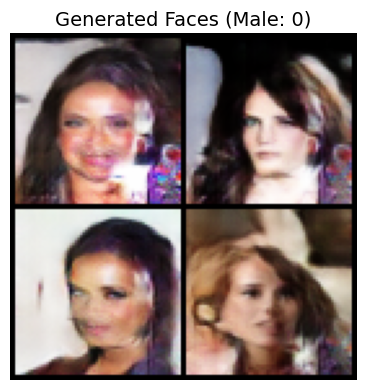

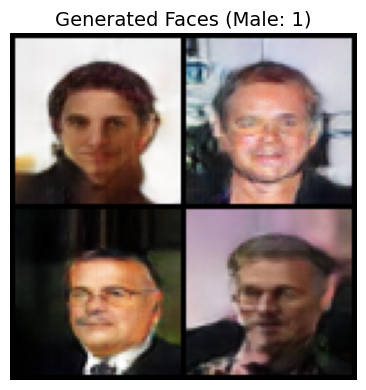

In [65]:
generator1 = load_generator("generator_1.pth")
generate_faces(generator1, 0, 4)
generate_faces(generator1, 1, 4)

Since the discriminator significantly outperformed the generator, we will add some restrictions and additional settings. We will implement different learning rates for the generator and discriminator to adjust their learning speed, as well as the step size that will indicate how many batches should pass for the next training.

In [ ]:
def train_cdcgan_2(epoch, lr_g, lr_d, step_g, step_d, loss, batch_size, img_size):
    # Initializing wandb
    config = {
"batch_size": batch_size, "learning_rate_generator": lr_g, "learning_rate_discriminator": lr_d, "noise": 100, "num_attrs": 1, "epochs": epoch, "img_size": img_size}
    cfg = init_wandb(f"Model-2", f"Image-Synthesis_CelebA", config)

    # Fixed data for visualization
    fixed_noise = torch.randn(4, cfg.noise).cuda()
    fixed_labels = torch.tensor([0., 1., 0., 1.], device='cuda')

    # Initializing DataLoader
    data_loader = create_data_loader(cfg.batch_size, True)

    # Creating models
    generator = create_generator(cfg.num_attrs, cfg.noise)
    discriminator = create_discriminator(num_attrs=cfg.num_attrs)

    # Initializing weights
    for m in generator.modules():
        normal_init(m, mean=0.0, std=0.02)
    for m in discriminator.modules():
        normal_init(m, mean=0.0, std=0.02)

    generator.cuda()
    discriminator.cuda()

    # Logging architectures
    wandb.watch(generator, log="parameters", log_freq=100)
    wandb.watch(discriminator, log="parameters", log_freq=100)

    # Initializing optimizers
    G_optimizer = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    D_optimizer = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))

    # Training loop
    for ep in range(1, epoch+1):
        G_losses, D_losses = [], []
        epoch_time = time.time()
        
        # Passing all dataframe by batches
        for batch_idx, (x_, y_) in enumerate(data_loader):
            # Preparing data
            x_ = x_.cuda()
            y_ = y_.cuda()

            # Labels for real and fake images
            y_real_ = torch.ones(x_.size(0)).cuda() * 0.9
            y_fake_ = torch.zeros(x_.size(0)).cuda() + 0.1

            # Training discriminator
            if batch_idx % step_d == 0:
                # Clearing gradients
                discriminator.zero_grad()

                # Real images
                D_real = discriminator_forward(discriminator, x_, y_)
                D_real_loss = loss(D_real, y_real_)

                # Fake images
                noise = torch.randn((x_.size(0), cfg.noise)).cuda()
                y_gen = torch.randint(0, 2, (x_.size(0),)).float().cuda()

                G_result = generator_forward(generator, noise, y_gen)
                D_fake = discriminator_forward(discriminator, G_result.detach(), y_gen)
                D_fake_loss = loss(D_fake, y_fake_)

                # Updating weights
                D_train_loss = D_real_loss + D_fake_loss
                D_train_loss.backward()
                D_optimizer.step()
                D_losses.append(D_train_loss.item())

            # Training generator
            if batch_idx % step_g == 0:
                # Clearing gradients
                generator.zero_grad()

                # Generating images
                y_gen = torch.randint(0, 2, (x_.size(0),)).float().cuda()
                G_result = generator_forward(generator, noise, y_gen)
                D_result = discriminator_forward(discriminator, G_result, y_gen)

                # Updating weights
                G_train_loss = loss(D_result, y_real_)
                G_train_loss.backward()
                G_optimizer.step()
                G_losses.append(G_train_loss.item())

            # Logging
            if (batch_idx + 1) % 50 == 0:
                wandb.log({
                    "G_loss_batch": G_train_loss.item(),
                    "D_loss_batch": D_train_loss.item()
                })

        # Saving examples after each epoch
        generator.eval()
        with torch.no_grad():
            samples = generator_forward(generator, fixed_noise, fixed_labels)
        generator.train()

        # Creating grid and logging to wandb
        grid = vutils.make_grid(samples, nrow=2, normalize=True, value_range=(-1, 1))

        wandb.log({
            "epoch": ep,
            "epoch_time": time.time() - epoch_time,
            "generated_faces_grid": wandb.Image(grid, caption=f"Epoch {ep}"),
        })

    # Saving models
    torch.save(generator.state_dict(), "generator_2.pth")
    torch.save(discriminator.state_dict(), "discriminator_2.pth")
    wandb.finish()

    return generator, discriminator

### Second attempt:

Training our model for 20 epochs with a learning rate = 0.0002 for the generator and 0.0001 for the discriminator, as well as a step = 1 for the generator and 2 for the discriminator.

From the third epoch, the generator and discriminator losses begin to fluctuate back and forth and cannot break through the threshold and improve further. The generator loss values range from 0.5 to 2.0, and the discriminator loss values range from 0.5 to 2.5.

The fluctuations are very large, and the images do not improve over time. This means that the training is unstable. So we need to stabilize our model.

In [ ]:
train_cdcgan_2(20, 0.0002, 0.0001, 1, 2, nn.BCELoss(), 64, 64)

Here we can see how our second model generates faces. The image quality did not improve as we expected, on the contrary, it became more blurred and unclear.

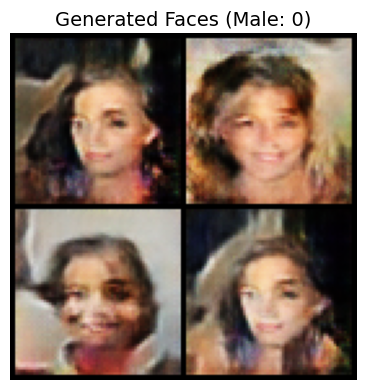

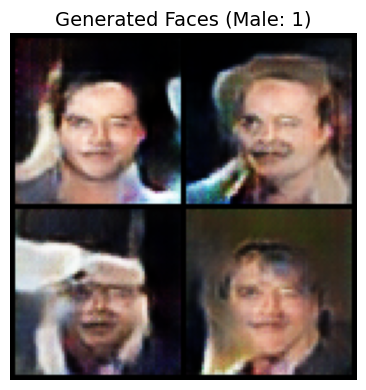

In [67]:
generator2 = load_generator("generator_2.pth")
generate_faces(generator2, 0, 4)
generate_faces(generator2, 1, 4)

Implement WGANLoss (Wasserstein GAN Loss) class, a loss function used in the Wasserstein GAN (WGAN) architecture. It is based on the Wasserstein distance and is designed to solve key problems of classical GANs.

Its difference is that it has different losses for the generator and discriminator. The discriminator loss forces real data to be given higher than fake data, while the generator maximizes the critic's evaluation.

In [ ]:
class WGANLoss(nn.Module):
    def __init__(self):
        super(WGANLoss, self).__init__()

    def forward(self, output, target):
        return output.mean()

    def generator_loss(self, d_fake):
        return -d_fake.mean()

    def discriminator_loss(self, d_real, d_fake):
        return -(d_real.mean() - d_fake.mean())

For more stable training, we have added the following changes to the training process:

Since we will be using WGAN, we replace the Adam optimizer with RMSProp. The WGAN critic is trained many times per generator step, and its gradients are often large, noisy, and uneven, so RMSProp will be better than ADAM because it adapts the learning rate more smoothly.

Also, because of WGAN, we add weight clipping, it means each critic parameter is clipped to the range (-0.01, 0.01) so that WGAN correctly measures the Wasserstein distance.


Finally, we add adaptive discrimination step correlation after the 5th epoch. If, at the end of the epoch, the average discrimination loss is less than 0.5 or the average generator loss is greater than 2.0, we increase the step by 1.


In [ ]:
def train_cdcgan_3(epoch, lr_g, lr_d, step_g, step_d, loss, batch_size, img_size):
     # Initializing wandb
    config = {
"batch_size": batch_size, "learning_rate_generator": lr_g, "learning_rate_discriminator": lr_d, "noise": 100, "num_attrs": 1, "epochs": epoch, "img_size": img_size}
    cfg = init_wandb(f"Model-3", f"Image-Synthesis_CelebA", config)

    # Fixed data for visualization
    fixed_noise = torch.randn(4, cfg.noise).cuda()
    fixed_labels = torch.tensor([0., 1., 0., 1.], device='cuda')

    # Initializing DataLoader
    data_loader = create_data_loader(cfg.batch_size, True)

    # Creating models
    generator = create_generator(cfg.num_attrs, cfg.noise)
    discriminator = create_discriminator(num_attrs=cfg.num_attrs)

    # Initializing weights
    for m in generator.modules():
        normal_init(m, mean=0.0, std=0.02)
    for m in discriminator.modules():
        normal_init(m, mean=0.0, std=0.02)

    generator.cuda()
    discriminator.cuda()

    # Logging architectures
    wandb.watch(generator, log="parameters", log_freq=100)
    wandb.watch(discriminator, log="parameters", log_freq=100)

    # Initializing optimizers
    G_optimizer = optim.RMSprop(generator.parameters(), lr=lr_g)
    D_optimizer = optim.RMSprop(discriminator.parameters(), lr=lr_d)

    # Training loop
    for ep in range(1, epoch+1):
        G_losses, D_losses = [], []
        epoch_time = time.time()

        # Passing all dataframe by batches
        for batch_idx, (x_, y_) in enumerate(data_loader):
            # Preparing data
            x_ = x_.cuda()
            y_ = y_.cuda()

            # Training discriminator
            if batch_idx % step_d == 0:
                # Clearing gradients
                discriminator.zero_grad()

                # Real images
                D_real = discriminator_forward(discriminator, x_, y_)

                # Fake images
                noise = torch.randn((x_.size(0), cfg.noise)).cuda()
                y_gen = torch.randint(0, 2, (x_.size(0),)).float().cuda()

                G_result = generator_forward(generator, noise, y_gen)
                D_fake = discriminator_forward(discriminator, G_result.detach(), y_gen)

                # Calculating loss
                D_train_loss = loss.discriminator_loss(D_real, D_fake)
                D_train_loss.backward()

                # Weight clipping
                for p in discriminator.parameters():
                    p.data.clamp_(-0.01, 0.01)

                # Updating weights
                D_optimizer.step()
                D_losses.append(D_train_loss.item())

            # Training generator
            if batch_idx % step_g == 0:
                # Clearing gradients
                generator.zero_grad()

                # Generating images
                noise = torch.randn((x_.size(0), cfg.noise)).cuda()
                y_gen = torch.randint(0, 2, (x_.size(0),)).float().cuda()
                G_result = generator_forward(generator, noise, y_gen)
                D_result = discriminator_forward(discriminator, G_result, y_gen)

                # Updating weights
                G_train_loss = loss.generator_loss(D_result)
                G_train_loss.backward()
                G_optimizer.step()
                G_losses.append(G_train_loss.item())

            # Logging with EMA
            if (batch_idx + 1) % 50 == 0:
                wandb.log({
                    "G_loss_batch": G_train_loss.item(),
                    "D_loss_batch": D_train_loss.item(),
                })

        # Saving examples after each epoch
        generator.eval()
        with torch.no_grad():
            samples = generator_forward(generator, fixed_noise, fixed_labels)
        generator.train()

        # Creating grid and log to wandb
        grid = vutils.make_grid(samples, nrow=2, normalize=True, value_range=(-1, 1))

        wandb.log({
            "epoch": ep,
            "epoch_time": time.time() - epoch_time,
            "generated_faces_grid": wandb.Image(grid, caption=f"Epoch {ep}"),
        })

        # Adaptive step_d correlation
        avg_g_loss = sum(G_losses) / len(G_losses) if G_losses else 0
        avg_d_loss = sum(D_losses) / len(D_losses) if D_losses else 0

        if ep > 5 and avg_d_loss < 0.5 and avg_g_loss > 2.0:
            step_d = min(step_d + 1, 5)
            wandb.log({"adjusted_step_d": step_d})

    # Saving models
    torch.save(generator.state_dict(), "generator_5.pth")
    torch.save(discriminator.state_dict(), "discriminator_5.pth")
    wandb.finish()

    return generator, discriminator

### Third attempt:

Training our model for 50 epochs, with learning rate = 0.00005, step = 5 for generator and 1 for discriminator.

As we can see from the loss graphs, the results have become better and more stable. The generator gradually improved, while the discriminator deteriorated, which means that the generator performed well.

In [ ]:
train_cdcgan_3(50, 0.00005, 0.00005, 5, 1, WGANLoss(), 64, 64)

Now we can check how our generator works. The faces are more or less human-like and the quality is clear.

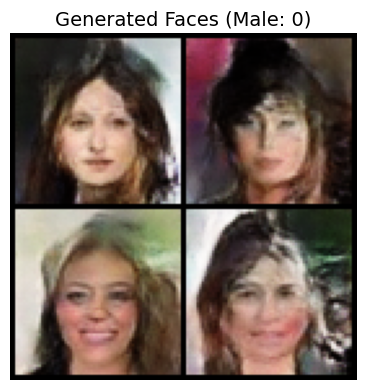

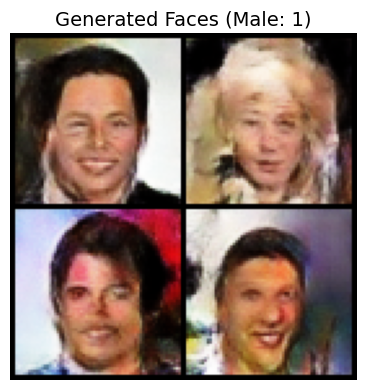

In [68]:
generator3 = load_generator("generator_3.pth")
generate_faces(generator3, 0, 4)
generate_faces(generator3, 1, 4)

### Wandb link: https://wandb.ai/dmytro44-stu-fiit/Image-Synthesis_CelebA